14:09:44 - cmdstanpy - INFO - Chain [1] start processing
14:09:45 - cmdstanpy - INFO - Chain [1] done processing


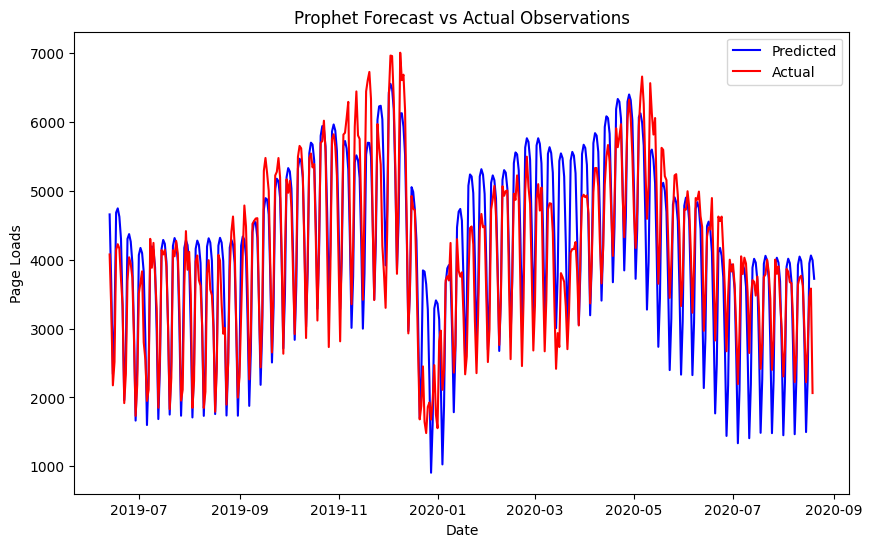

In [22]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Load your dataset
df = pd.read_csv('data.csv')

# Convert the 'Date' column to datetime format and prepare the data
df['Date'] = pd.to_datetime(df['Date'])
df['Page.Loads'] = df['Page.Loads'].str.replace(',', '').astype(int)
df = df.rename(columns={'Date': 'ds', 'Page.Loads': 'y'})

# Splitting the dataset into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]


# Initialize and fit the Prophet model on the TRAINING data
model = Prophet()
model.fit(train_df)

# Create a future dataframe that covers the period of the test set
# Note: The test set's period is essentially from the last point in the training set to the end of the test set.
last_train_date = train_df['ds'].max()
first_test_date = test_df['ds'].min()
last_test_date = test_df['ds'].max()

# Ensure the future dataframe includes the test set period
future_dates = model.make_future_dataframe(periods=(last_test_date - last_train_date).days + 1, include_history=False)

# Predict the future with the model
forecast = model.predict(future_dates)

# Plot the forecast alongside the actual observations from the test set
# First, plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='blue')

# Then, plot the actual values from the test set
plt.plot(test_df['ds'], test_df['y'], label='Actual', color='red')

plt.title('Prophet Forecast vs Actual Observations')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()